In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import keras
import tensorflow as tf
from keras import models, layers, optimizers, callbacks, regularizers, initializers
from scikeras.wrappers import KerasClassifier

2024-06-18 17:51:07.549261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('dataset_preprocessed/tabular/joined_dataset.csv')

In [3]:
df.shape

(87259, 29)

In [4]:
df.columns

Index(['id', 'name', 'disc_number', 'duration_ms', 'explicit', 'popularity',
       'artists', 'album_type', 'album_name', 'album_release_date',
       'album_release_date_precision', 'album_total_tracks', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'tempo_confidence', 'time_signature_confidence', 'key_confidence',
       'genre', 'artist_popularity'],
      dtype='object')

In [5]:
X = df.drop(columns=[
    'id',
    'name',
    'disc_number',
    'explicit',
    'artists',
    'album_type',
    'album_name',
    'album_release_date',
    'album_release_date_precision',
    'key',
    'mode',
    'time_signature',
    'genre',
    'artist_popularity']).values

y = df['artist_popularity'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
def my_nn(hidden_layers, activation, lr, reg_type, reg_lambda, optimizer, momentum):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

    for units in hidden_layers:
        model.add(layers.Dense(units=units,
                               activation=activation,
                               kernel_regularizer=reg_type(reg_lambda)))
    
    model.add(layers.Dense(units=1,
                           activation='linear',
                           kernel_regularizer=reg_type(reg_lambda)))

    if optimizer == 'adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        optimizer = optimizers.SGD(learning_rate=lr, momentum=momentum)
    
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

# NN1

In [9]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=True)
mc = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model = my_nn(hidden_layers=[128, 256, 128],
              activation='relu',
              lr=0.001,
              reg_type=regularizers.l1,
              reg_lambda=0.01,
              optimizer='adam',
              momentum=0.9)

history = model.fit(epochs=1000,
                    x=X_train_scaled,
                    y=y_train,
                    shuffle=True,
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1904.1925 - mean_absolute_error: 38.1035 - val_loss: 341.2703 - val_mean_absolute_error: 13.6534
Epoch 2/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 321.8736 - mean_absolute_error: 13.1874 - val_loss: 284.9973 - val_mean_absolute_error: 12.3182
Epoch 3/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 278.4197 - mean_absolute_error: 12.2553 - val_loss: 252.1549 - val_mean_absolute_error: 11.5870
Epoch 4/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 245.1475 - mean_absolute_error: 11.5225 - val_loss: 231.6441 - val_mean_absolute_error: 11.0949
Epoch 5/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 229.5367 - mean_absolute_error: 11.1147 - val_loss: 219.6033 - val_mean_absolute_error: 10.8091
Epoch 6/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 218.0552 - mean_absolute_error: 10.8325 - val_loss: 211.0905 - val_mean_absolute_error: 10.5892
Epoch 7/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss:

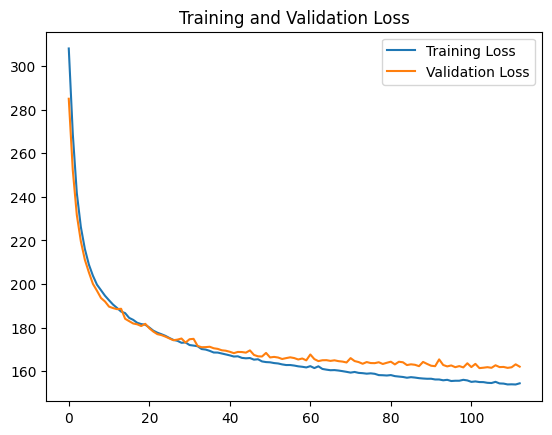

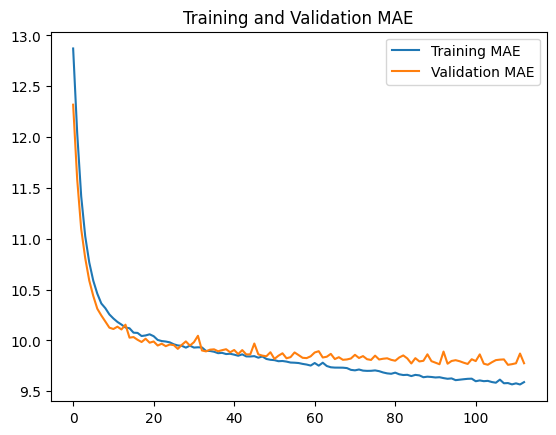

In [12]:
# Plot training and validation loss
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.savefig('./img/Advanced Regression/nn_mse.png', dpi=300, bbox_inches='tight')

plt.show()

# Plot training and validation MAE
plt.plot(history.history['mean_absolute_error'][1:], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'][1:], label='Validation MAE')
plt.legend()
plt.title('Training and Validation MAE')

plt.savefig('./img/Advanced Regression/nn_mae.png', dpi=300, bbox_inches='tight')

plt.show()

In [20]:
# Check test performance with r2_score, mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test_scaled)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
R2 Score: 0.4746226842019946
Mean Squared Error: 154.98511957695362
Mean Absolute Error: 9.819173616152709


# NN2

In [70]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=True)
mc = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model = my_nn(hidden_layers=[2, 4, 4, 2],
              activation='relu',
              lr=0.01,
              reg_type=regularizers.l1,
              reg_lambda=0.005,
              optimizer='adam',
              momentum=0.9)

history = model.fit(epochs=1000,
                    x=X_train_scaled,
                    y=y_train,
                    shuffle=True,
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2616.1013 - mean_absolute_error: 48.1447 - val_loss: 2556.1970 - val_mean_absolute_error: 47.5639
Epoch 2/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2570.6587 - mean_absolute_error: 47.6594 - val_loss: 2504.5188 - val_mean_absolute_error: 47.0233
Epoch 3/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2510.8330 - mean_absolute_error: 47.0469 - val_loss: 2453.7412 - val_mean_absolute_error: 46.4859
Epoch 4/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2465.8647 - mean_absolute_error: 46.5809 - val_loss: 2403.8494 - val_mean_absolute_error: 45.9522
Epoch 5/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2413.7188 - mean_absolute_error: 46.0305 - val_loss: 2354.7739 - val_mean_absolute_error: 45.4222
Epoch 6/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2353.5044 - mean_absolute_error: 45.3583 - val_loss: 2306.5613 - val_mean_absolute_error: 44.8965
Epoch 7/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

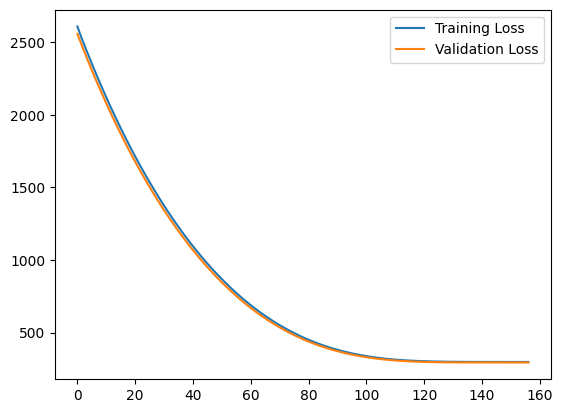

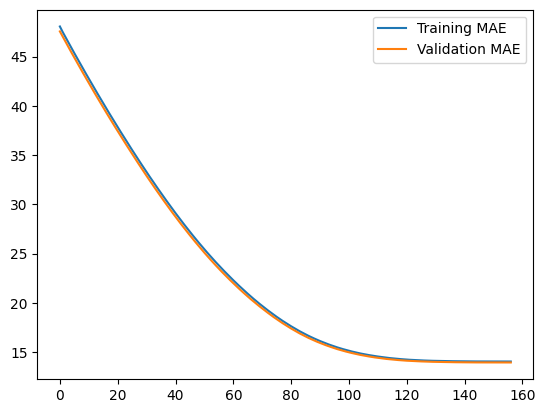

In [71]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.show()

In [72]:
# Check test performance with r2_score, mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test_scaled)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step
R2 Score: -2.304054689039603e-06
Mean Squared Error: 294.99841734836764
Mean Absolute Error: 13.943807853143854


# NN3

In [73]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=True)
mc = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model = my_nn(hidden_layers=[16, 32],
              activation='relu',
              lr=0.01,
              reg_type=regularizers.l1,
              reg_lambda=0.1,
              optimizer='adam',
              momentum=0.9)

history = model.fit(epochs=1000,
                    x=X_train_scaled,
                    y=y_train,
                    shuffle=True,
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1848.1746 - mean_absolute_error: 37.7246 - val_loss: 310.8887 - val_mean_absolute_error: 13.4663
Epoch 2/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 280.9788 - mean_absolute_error: 12.7921 - val_loss: 240.5746 - val_mean_absolute_error: 11.7401
Epoch 3/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 234.0834 - mean_absolute_error: 11.6737 - val_loss: 221.9244 - val_mean_absolute_error: 11.3177
Epoch 4/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 218.4444 - mean_absolute_error: 11.2742 - val_loss: 212.7975 - val_mean_absolute_error: 11.0863
Epoch 5/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 211.4020 - mean_absolute_error: 11.1201 - val_loss: 206.6281 - val_mean_absolute_error: 10.9658
Epoch 6/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 206.9279 - mean_absolute_error: 11.0250 - val_loss: 202.6620 - val_mean_absolute_error: 10.8630
Epoch 7/1000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 202

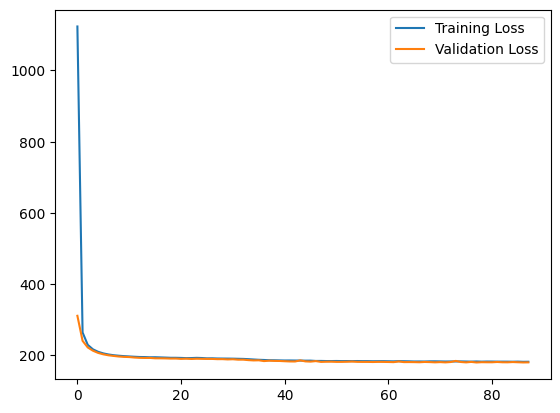

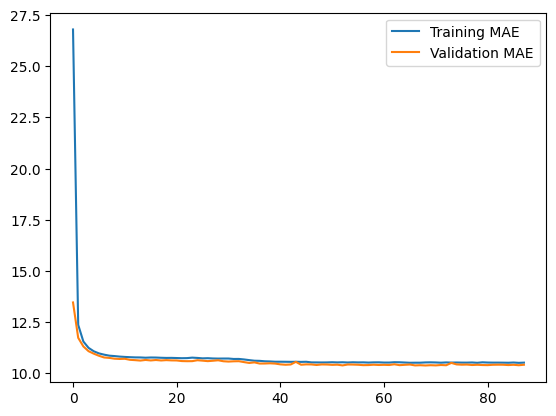

In [74]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.show()

In [75]:
# Check test performance with r2_score, mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test_scaled)
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step
R2 Score: 0.40845159720704494
Mean Squared Error: 174.50544053879787
Mean Absolute Error: 10.491410013919653
